
Made by Roman Kiryanov, roman.kiryanov@skoltech.ru


## Initialization

### Preinstall required libraries

In [0]:
#!pip install dlib
#!pip install opencv-python
#!pip install --upgrade imutils

import dlib
import cv2

import numpy as np
import pandas as pd

import imutils
import os

from PIL import Image

from matplotlib import pyplot as plt

### Drive mounting for Data

In [0]:
# mounting drive folder

from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = 'gdrive/My Drive/Colab Notebooks/DL_Project/'
cwd = os.getcwd()
os.chdir(path)

## Get table data

In [0]:
datadir = 'Twins'

metadata = pd.read_csv(f'{datadir}/twins-relationship-info.csv', index_col = 0)
metadata['subject_id1'] = metadata['subject_id1'].apply(lambda x: int(x.split('S')[1]))
metadata['subject_id2'] = metadata['subject_id2'].apply(lambda x: int(x.split('S')[1]))

# filter 
metadata_identical = metadata[(metadata['relationship_type']=='Identical')]
metadata_fraternal = metadata[(metadata['relationship_type']=='Fraternal')]
metadata_sibling   = metadata[(metadata['relationship_type']=='Sibling')]

metadata_different = metadata[(metadata['relationship_type']=='Fraternal') | (metadata['relationship_type']=='Sibling')]

print(len(metadata_identical), len(metadata_fraternal), len(metadata_sibling), len(metadata_different))
metadata_different.head()


352 32 8 40


,subject_id1,subject_id2,relationship_type
1,90004,90005,Fraternal
2,90005,90004,Fraternal
3,90006,90007,Fraternal
4,90007,90006,Fraternal
26,90029,90030,Fraternal


### Convert table data to dict
Я использую Counter так как обычный дикт при запросе несуществующего элемента выкинет ошибку, а этот - 0

In [0]:
from collections import Counter

In [0]:
identical = Counter()
for i, subj_id1 in enumerate( metadata_identical[['subject_id1', 'subject_id2']].values):  
    identical[subj_id1[0]] = subj_id1[1]

In [0]:
different = Counter()
for i, subj_id1 in enumerate( metadata_different[['subject_id1', 'subject_id2']].values):  
    different[subj_id1[0]] = subj_id1[1]

In [0]:
fraternal = Counter()
for i, subj_id1 in enumerate( metadata_fraternal[['subject_id1', 'subject_id2']].values):  
    fraternal[subj_id1[0]] = subj_id1[1]

sibling = Counter()
for i, subj_id1 in enumerate( metadata_sibling[['subject_id1', 'subject_id2']].values):  
    sibling[subj_id1[0]] = subj_id1[1]

### One more table with views
Сортировка информации о том какие файлы какие имеют виды. Берем только фронтальные

In [0]:
datadir = 'Twins'

metadata2 = pd.read_csv(f'{datadir}/image-metadata-2.0.csv')
# filter 
metadata2 = metadata2[(metadata2[' yaw']==0)&(metadata2[' expression']!=' Happiness')&(metadata2[' glasses']==' none')]
metadata2['person_id'] = metadata2['filename'].apply(lambda x: int(x.split('d')[0]))
metadata2['view_id'] = metadata2['filename'].apply(lambda x: x.split('d')[1].split('.')[0])

df_ids_views = metadata2.groupby('person_id').view_id.apply(tuple).to_frame()

In [0]:
df_ids_views.head()

,view_id
person_id,
90003,"(17, 18, 40, 42, 60, 61)"
90004,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90005,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90006,"(14, 15, 37, 39, 57, 58)"
90007,"(17, 18, 36, 54, 55)"


In [0]:
views = Counter()
for i, num in enumerate( list(df_ids_views.index) ):
    views[num] = list(df_ids_views.values)[i]

### Data Loader
Простенький даталоадер который берет изображение, определяет по таблице близнеца и загружает все возможные пары видов

In [0]:
def get_img_path(img_id, view):
    return os.path.join('Twins','nd-twins-0006/faces', f'{img_id}/{img_id}d{view}__face.jpg')

In [0]:
def load(pairs, views):
    for id_a in pairs.keys():
        id_b = pairs[id_a]
        
        views_a = views[id_a][0]
        views_b = views[id_b][0] #        view_b = np.random.choice(views[id_b][0]) 
        for i in views_a:
            for j in views_b:
                path_a = get_img_path(id_a, i)
                path_b = get_img_path(id_b, j)
                im_A = Image.open(path_a)
                im_B = Image.open(path_b)
                yield [im_A, im_B]

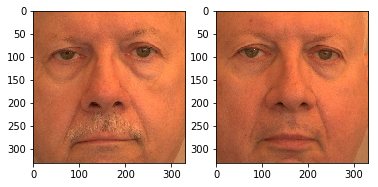

In [0]:
a = next(iter(load(fraternal, views)))
plt.subplot(121)
plt.imshow(a[0])
plt.subplot(122)
plt.imshow(a[1])

## Get face landmark coordinates

In [0]:
os.chdir(cwd)
from dlib_fd import dlib_landmark_detector # face detector
from hr_e import head_rotation_estimator # rotation estimation

In [0]:
os.chdir(path)

In [0]:
# initialize detector:
# cnn_flag = True to use CNN-based model.If False, use HOG-based model
# bb_detector_path = full path except name to bounding box detector (first stage of face detection)
# landmark_predictor_path = full path except name to 68-points trained weights for detector of face landmarks

dfd = dlib_landmark_detector(cnn_flag='True', 
                             bb_detector_path = './mmod_human_face_detector.dat', 
                             landmark_predictor_path = './shape_predictor_68_face_landmarks.dat' )

In [0]:
def distance(shape1, shape2): 
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1)) #MSE

### Twins Features Generator

**Get train features on siblings class**

In [0]:
different_lines, angles = [], []
counter, nd = 1, 0

# Train on siblings

# Here in load( counter_from_metadata, counter_from)
for [img_A, img_B] in iter(load(sibling, views)):
    # Face A prepare
    img_8bit = np.array( img_A )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    # Face A detect
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    # Face A crop and center
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    # Face A get landmark points
    A__img_shape = dfd.get_original_size_landmarks()
    
    # Estimate head rotation
    if A__img_shape is not None:
        hre = head_rotation_estimator(A__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_A = hre.horizontal_angle
        vertical_angle_A = hre.vertical_angle

    # Face B - the same
    img_8bit = np.array( img_B )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    B__img_shape = dfd.get_original_size_landmarks()
    
    if B__img_shape is not None:
        hre = head_rotation_estimator(B__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_B = hre.horizontal_angle
        vertical_angle_B = hre.vertical_angle
    
    
    if (A__img_shape is None) or (B__img_shape is None):
        print('warning')
        nd +=1
    else:
        different_lines.append(distance(A__img_shape, B__img_shape))
        angles.append([[horizontal_angle_A, vertical_angle_A],
                       [horizontal_angle_B, vertical_angle_B]])
    counter+=1

print(counter, nd)
angles = np.array(angles)

97 0


**Get test features on FRATERNAL class**

In [0]:
fraternal_lines, fraternal_angles = [], []
counter, nd = 1, 0

# FRATERNAL

for [img_A, img_B] in iter(load(fraternal, views)):
    # Face A
    img_8bit = np.array( img_A )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    A__img_shape = dfd.get_original_size_landmarks()
    
    if A__img_shape is not None:
        hre = head_rotation_estimator(A__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_A = hre.horizontal_angle
        vertical_angle_A = hre.vertical_angle

    # Face B
    img_8bit = np.array( img_B )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    B__img_shape = dfd.get_original_size_landmarks()
    
    if B__img_shape is not None:
        hre = head_rotation_estimator(B__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_B = hre.horizontal_angle
        vertical_angle_B = hre.vertical_angle
    
    
    if (A__img_shape is None) or (B__img_shape is None):
        print('warning')
        nd +=1
    else:
        fraternal_lines.append(distance(A__img_shape, B__img_shape))
        fraternal_angles.append([[horizontal_angle_A, vertical_angle_A],
                       [horizontal_angle_B, vertical_angle_B]])
    counter+=1

print(counter, nd)
fraternal_angles = np.array(fraternal_angles)

warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
warning
853 12


#### Plot

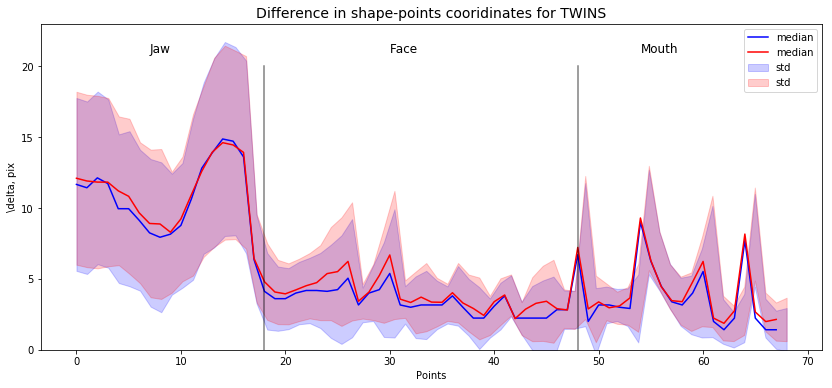

In [0]:
d_median = np.median(different_lines, axis=0)
d_mean = np.mean(different_lines, axis=0)
d_std = np.std(different_lines, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211)
#for l in different_lines:
#  plt.plot(l)

#plt.subplot(212)
plt.plot(d_median,'blue', label='median', )
plt.fill_between( np.linspace(0,68,68), d_median+d_std, d_median-d_std, color='blue', alpha=0.2, label='std')
plt.plot(d_mean, 'red', label='median')
plt.fill_between( np.linspace(0,68,68), d_mean+d_std, d_mean-d_std, color='red', alpha=0.2, label='std')

plt.plot(np.ones(10)*18,np.linspace(-1,20,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-1,20,10),'black',alpha=0.5)
plt.text(7,21,'Jaw', fontsize=12)
plt.text(30,21,'Face', fontsize=12)
plt.text(54,21,'Mouth', fontsize=12)

plt.title('Difference in shape-points cooridinates for TWINS', fontsize=14)
plt.xlabel('Points')
plt.ylabel('\delta, pix')
plt.ylim([0,23])

plt.legend()
plt.show()

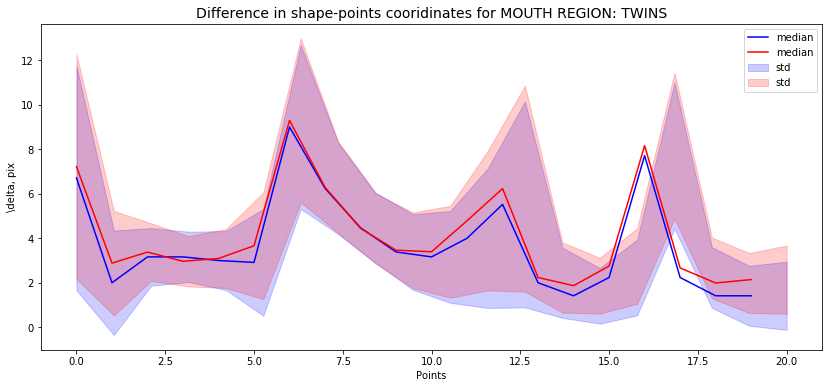

In [0]:
mouth_d = np.array(different_lines)[:,48:]

mouth__d_median = np.median(mouth_d, axis=0)
mouth__d_mean = np.mean(mouth_d, axis=0)
mouth__d_std = np.std(mouth_d, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211)
#for l in mouth_d :
#  plt.plot(l)

#plt.subplot(212)
plt.plot(mouth__d_median,'blue', label='median', )
plt.fill_between( np.linspace(0,20,20), mouth__d_median+mouth__d_std, mouth__d_median-mouth__d_std, color='blue', alpha=0.2, label='std')
plt.plot(mouth__d_mean, 'red', label='median')
plt.fill_between( np.linspace(0,20,20), mouth__d_mean+mouth__d_std, mouth__d_mean-mouth__d_std, color='red', alpha=0.2, label='std')

plt.title('Difference in shape-points cooridinates for MOUTH REGION: TWINS', fontsize=14)
plt.xlabel('Points')
plt.ylabel('\delta, pix')

plt.legend()
plt.show()

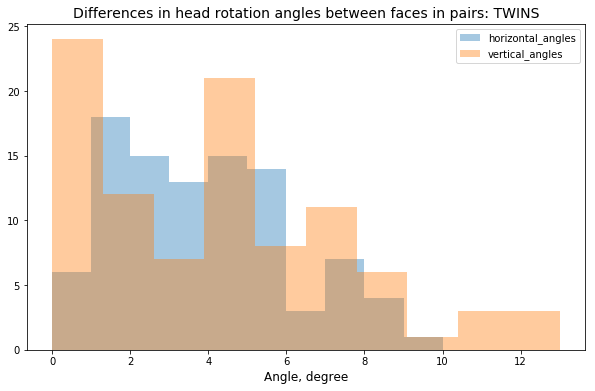

In [0]:
plt.figure(figsize=(10,6))
plt.hist(abs(angles[:,0,0] - angles[:,1,0]), alpha=0.4, label='horizontal_angles')
plt.hist(abs(angles[:,0,1] - angles[:,1,1]), alpha=0.4, label='vertical_angles')
plt.legend()
plt.xlabel('Angle, degree', fontsize=12)
plt.title('Differences in head rotation angles between faces in pairs: TWINS', fontsize=14)
plt.show()

### Flipped Features Generator

In [0]:
one_person_lines, on_angles = [], []

counter, nd = 1, 0
stop_counter = 100

for [img_A, img_B] in iter(load(identical, views)):
    img_8bit = np.array( img_A )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    A__img_shape = dfd.get_original_size_landmarks()
    
    if A__img_shape is not None:
        hre = head_rotation_estimator(A__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_A = hre.horizontal_angle
        vertical_angle_A = hre.vertical_angle

        
    face_cropped = np.flip(face_cropped, axis=1)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    B__img_shape = dfd.get_original_size_landmarks()
    
    if B__img_shape is not None:
        hre = head_rotation_estimator(B__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_B = hre.horizontal_angle
        vertical_angle_B = hre.vertical_angle
    
    if (A__img_shape is None) or (B__img_shape is None):
        print('warning')
        nd +=1
    else:
        one_person_lines.append(distance(A__img_shape, B__img_shape))
        on_angles.append([[horizontal_angle_A, vertical_angle_A],
                       [horizontal_angle_B, vertical_angle_B]])
    counter+=1
    if counter == stop_counter:
        break

print(counter, nd)
on_angles = np.array(on_angles)

100 0


#### Plot

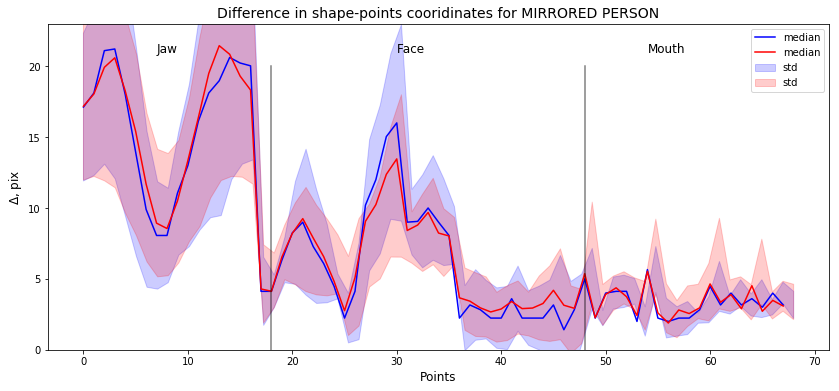

In [0]:
op_median = np.median(one_person_lines, axis=0)
op_mean = np.mean(one_person_lines, axis=0)
op_std = np.std(one_person_lines, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211)
#for l in one_person_lines:
#  plt.plot(l)

#plt.subplot(212)
plt.plot(op_median,'blue', label='median', )
plt.fill_between( np.linspace(0,68,68), op_median+op_std, op_median-op_std, color='blue', alpha=0.2, label='std')
plt.plot(op_mean, 'red', label='median')
plt.fill_between( np.linspace(0,68,68), op_mean+d_std, op_mean-op_std, color='red', alpha=0.2, label='std')

plt.plot(np.ones(10)*18,np.linspace(-1,20,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-1,20,10),'black',alpha=0.5)
plt.text(7,21,'Jaw', fontsize=12)
plt.text(30,21,'Face', fontsize=12)
plt.text(54,21,'Mouth', fontsize=12)

plt.title('Difference in shape-points cooridinates for MIRRORED PERSON', fontsize=14)
plt.xlabel('Points', fontsize=12)
plt.ylabel('$\Delta$, pix', fontsize=12)
plt.ylim([0,23])

plt.legend()
plt.show()

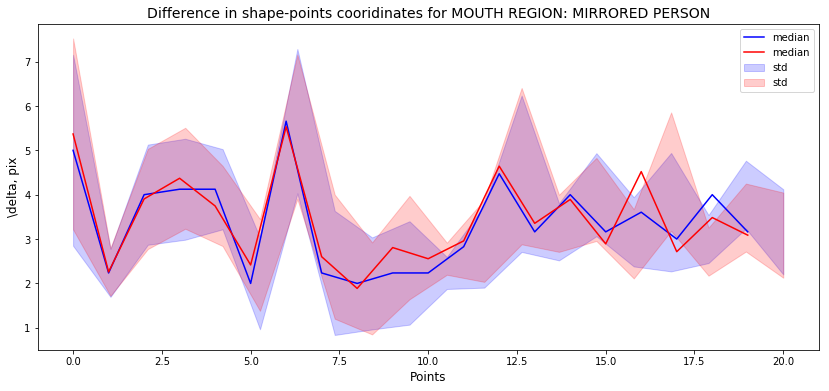

In [0]:
mouth_i = np.array(one_person_lines)[:,48:]

mouth__i_median = np.median(mouth_i, axis=0)
mouth__i_mean = np.mean(mouth_i, axis=0)
mouth__i_std = np.std(mouth_i, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211)
#for l in mouth_i :
#  plt.plot(l)

#plt.subplot(212)
plt.plot(mouth__i_median,'blue', label='median', )
plt.fill_between( np.linspace(0,20,20), mouth__i_median+mouth__i_std, mouth__i_median-mouth__i_std, color='blue', alpha=0.2, label='std')
plt.plot(mouth__i_mean, 'red', label='median')
plt.fill_between( np.linspace(0,20,20), mouth__i_mean+mouth__i_std, mouth__i_mean-mouth__i_std, color='red', alpha=0.2, label='std')

plt.title('Difference in shape-points cooridinates for MOUTH REGION: MIRRORED PERSON', fontsize=14)
plt.xlabel('Points', fontsize = 12)
plt.ylabel('\delta, pix', fontsize = 12)

plt.legend()
plt.show()

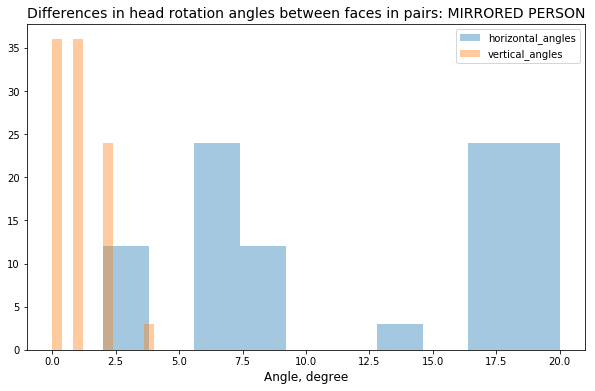

In [0]:
plt.figure(figsize=(10,6))
plt.hist(abs(on_angles[:,0,0] - on_angles[:,1,0]), alpha=0.4, label='horizontal_angles')
plt.hist(abs(on_angles[:,0,1] - on_angles[:,1,1]), alpha=0.4, label='vertical_angles')
plt.legend()
plt.xlabel('Angle, degree', fontsize=12)
plt.title('Differences in head rotation angles between faces in pairs: MIRRORED PERSON', fontsize=14)
plt.show()


### The same person, but from differen folder Generator

In [0]:
same_person_lines, same_angles = [], []

counter, nd = 1, 0

counter_stop = 100

for [img_A, img_B] in iter(load(identical, views)):
    img_8bit = np.array( img_A )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    A__img_shape = dfd.get_original_size_landmarks()
    
    if A__img_shape is not None:
        hre = head_rotation_estimator(A__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_A = hre.horizontal_angle
        vertical_angle_A = hre.vertical_angle

        
     # Face B
    img_8bit = np.array( img_B )
    img_8bit_pad = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
    dfd.reset()
    dfd.face_detect(img_8bit_pad, visualize=False)
    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
    dfd.reset()
    dfd.face_detect(face_cropped, visualize=False)
    B__img_shape = dfd.get_original_size_landmarks()
    
    if B__img_shape is not None:
        hre = head_rotation_estimator(B__img_shape, verbose=False)
        hre.get_horizontal_rotation_angles()
        hre.get_vertical_angles()
        horizontal_angle_B = hre.horizontal_angle
        vertical_angle_B = hre.vertical_angle
    
    
    if (A__img_shape is None) or (B__img_shape is None):
        print('warning')
        nd +=1
    else:
        same_person_lines.append(distance(A__img_shape, B__img_shape))
        same_angles.append([[horizontal_angle_A, vertical_angle_A],
                       [horizontal_angle_B, vertical_angle_B]])
        counter+=1

    
    if counter == counter_stop:
        break

print(counter, nd)
same_angles = np.array(same_angles)

100 0


#### Plot

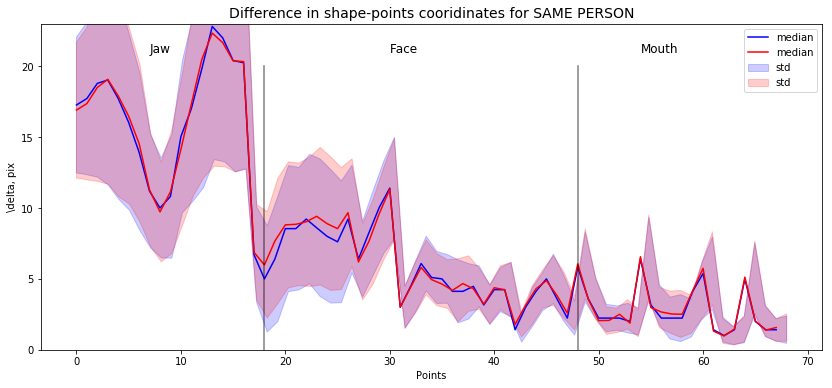

In [0]:
same_median = np.median(same_person_lines, axis=0)
same_mean = np.mean(same_person_lines, axis=0)
same_std = np.std(same_person_lines, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211, title='Same person')
#for l in same_person_lines:
#  plt.plot(l)

#plt.subplot(212, title='Same person')
plt.plot(same_median,'blue', label='median', )
plt.fill_between( np.linspace(0,68,68), same_median+same_std, same_median-same_std, color='blue', alpha=0.2, label='std')
plt.plot(same_mean, 'red', label='median')
plt.fill_between( np.linspace(0,68,68), same_mean+same_std, same_mean-same_std, color='red', alpha=0.2, label='std')

plt.plot(np.ones(10)*18,np.linspace(-1,20,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-1,20,10),'black',alpha=0.5)
plt.text(7,21,'Jaw', fontsize=12)
plt.text(30,21,'Face', fontsize=12)
plt.text(54,21,'Mouth', fontsize=12)

plt.title('Difference in shape-points cooridinates for SAME PERSON', fontsize=14)
plt.xlabel('Points')
plt.ylabel('\delta, pix')
plt.ylim([0,23])

plt.legend()
plt.show()

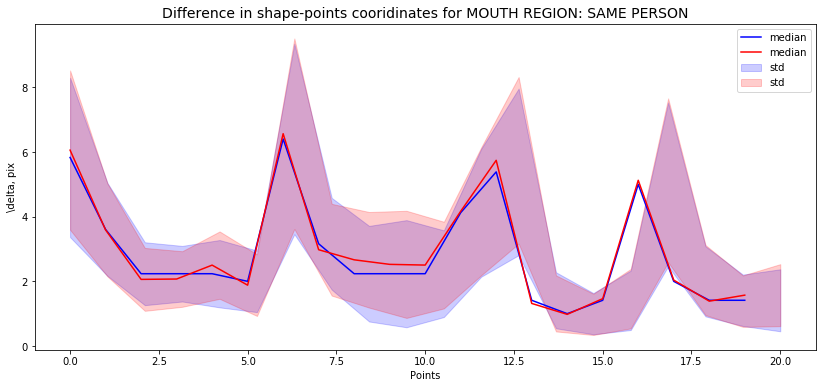

In [0]:
mouth_same = np.array(same_person_lines)[:,48:]

mouth__same_median = np.median(mouth_same, axis=0)
mouth__same_mean = np.mean(mouth_same, axis=0)
mouth__same_std = np.std(mouth_same, axis=0)


plt.figure(figsize=(14,6))
#plt.subplot(211, title='Same mouth')
#for l in mouth_same :
#  plt.plot(l)

#plt.subplot(212, title='Same mouth')
plt.plot(mouth__same_median,'blue', label='median', )
plt.fill_between( np.linspace(0,20,20), mouth__same_median+mouth__same_std, mouth__same_median-mouth__same_std, color='blue', alpha=0.2, label='std')
plt.plot(mouth__same_mean, 'red', label='median')
plt.fill_between( np.linspace(0,20,20), mouth__same_mean+mouth__same_std, mouth__same_mean-mouth__same_std, color='red', alpha=0.2, label='std')

plt.title('Difference in shape-points cooridinates for MOUTH REGION: SAME PERSON', fontsize=14)
plt.xlabel('Points')
plt.ylabel('\delta, pix')

plt.legend()
plt.show()

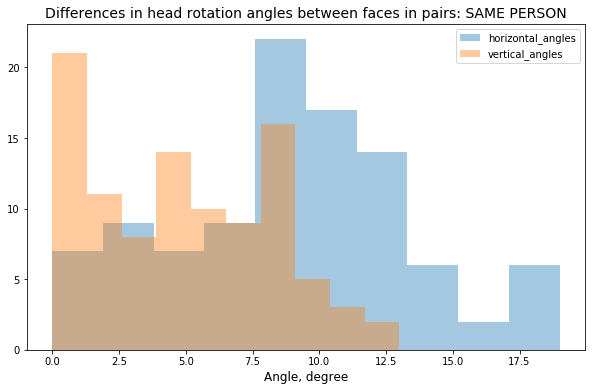

In [0]:
plt.figure(figsize=(10,6))
plt.hist(abs(same_angles[:,0,0] - same_angles[:,1,0]), alpha=0.4, label='horizontal_angles')
plt.hist(abs(same_angles[:,0,1] - same_angles[:,1,1]), alpha=0.4, label='vertical_angles')
plt.legend()
plt.xlabel('Angle, degree', fontsize=12)
plt.title('Differences in head rotation angles between faces in pairs: SAME PERSON', fontsize=14)
plt.show()

## Results Cumulative plot

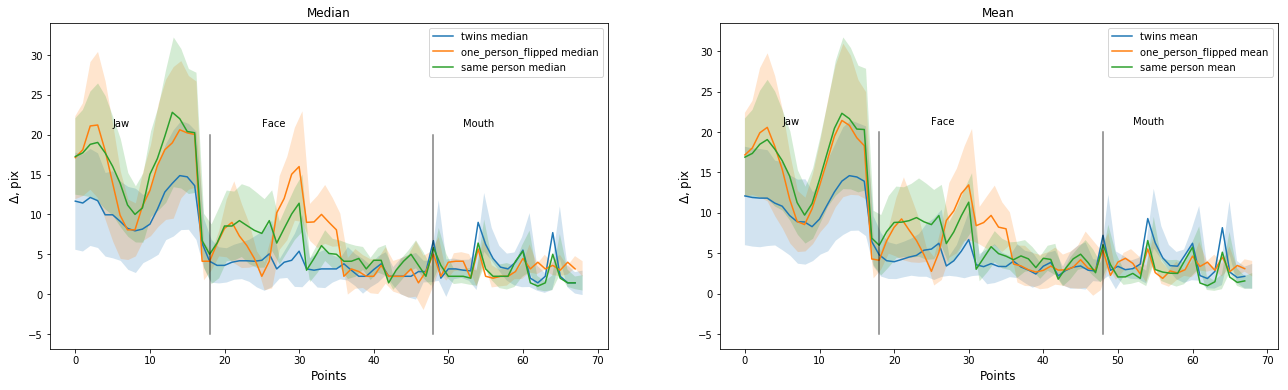

In [0]:
plt.figure(figsize=(22,6))
plt.subplot(121, title='Median')

plt.plot(d_median, label='twins median')
plt.fill_between( np.linspace(0,68,68), d_median+d_std, d_median-d_std, alpha=0.2)

plt.plot(op_median, label='one_person_flipped median')
plt.fill_between( np.linspace(0,68,68), op_median+op_std, op_median-op_std, alpha=0.2)

plt.plot(same_median, label='same person median')
plt.fill_between( np.linspace(0,68,68), same_median+same_std, same_median-same_std, alpha=0.2)
plt.legend()

plt.plot(np.ones(10)*18,np.linspace(-5,20,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-5,20,10),'black',alpha=0.5)
plt.text(5,21,'Jaw')
plt.text(25,21,'Face')
plt.text(52,21,'Mouth')

plt.xlabel('Points', fontsize=12)
plt.ylabel('$\Delta$, pix', fontsize=12)


plt.subplot(122, title="Mean")
plt.plot(d_mean, label='twins mean')
plt.fill_between( np.linspace(0,68,68), d_mean+d_std, d_mean-d_std, alpha=0.2)

plt.plot(op_mean, label='one_person_flipped mean')
plt.fill_between( np.linspace(0,68,68), op_mean+op_std, op_mean-op_std, alpha=0.2)

plt.plot(same_mean, label='same person mean')
plt.fill_between( np.linspace(0,68,68), same_mean+same_std, same_mean-same_std, alpha=0.2)
plt.legend()

plt.plot(np.ones(10)*18,np.linspace(-5,20,10),'black',alpha=0.5)
plt.plot(np.ones(10)*48,np.linspace(-5,20,10),'black',alpha=0.5)
plt.text(5,21,'Jaw')
plt.text(25,21,'Face')
plt.text(52,21,'Mouth')

plt.xlabel('Points', fontsize=12)
plt.ylabel('$\Delta$, pix', fontsize=12)
plt.show()

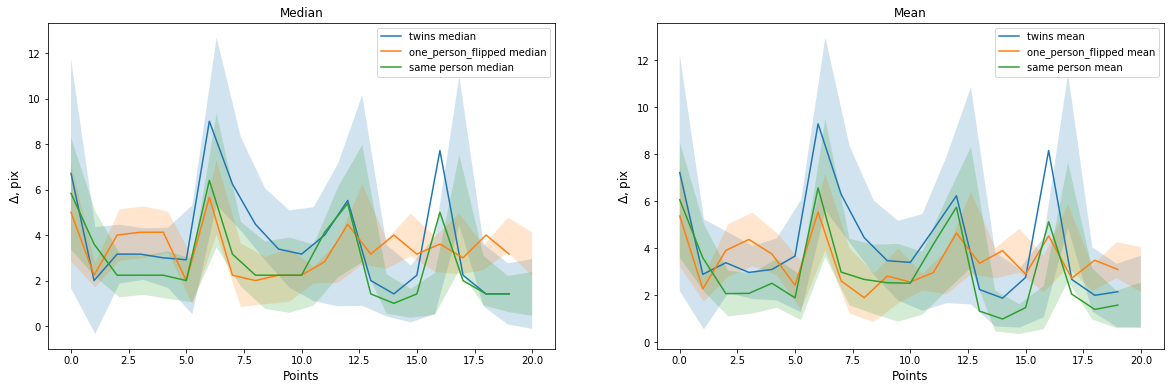

In [0]:
plt.figure(figsize=(20,6))
plt.subplot(121, title='Median')
plt.plot(mouth__d_median, label='twins median')
plt.fill_between( np.linspace(0,20,20), mouth__d_median+mouth__d_std, mouth__d_median-mouth__d_std, alpha=0.2)

plt.plot(mouth__i_median, label='one_person_flipped median')
plt.fill_between( np.linspace(0,20,20), mouth__i_median+mouth__i_std, mouth__i_median-mouth__i_std, alpha=0.2)

plt.plot(mouth__same_median, label='same person median')
plt.fill_between( np.linspace(0,20,20), mouth__same_median+mouth__same_std, mouth__same_median-mouth__same_std, alpha=0.2)

plt.xlabel('Points', fontsize=12)
plt.ylabel('$\Delta$, pix', fontsize=12)
plt.legend()

plt.subplot(122, title="Mean")
plt.plot(mouth__d_mean, label='twins mean')
plt.fill_between( np.linspace(0,20,20), mouth__d_mean+mouth__d_std, mouth__d_mean-mouth__d_std, alpha=0.2)

plt.plot(mouth__i_mean, label='one_person_flipped mean')
plt.fill_between( np.linspace(0,20,20), mouth__i_mean+mouth__i_std, mouth__i_mean-mouth__i_std, alpha=0.2)

plt.plot(mouth__same_mean, label='same person mean')
plt.fill_between( np.linspace(0,20,20), mouth__same_mean+mouth__same_std, mouth__same_mean-mouth__same_std, alpha=0.2)

plt.xlabel('Points', fontsize=12)
plt.ylabel('$\Delta$, pix', fontsize=12)
plt.legend()
plt.show()

## SVM Classifier

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

**Get only mouth features**

In [0]:
mouth_same = np.array(same_person_lines)[:,48:]
mouth_d = np.array(different_lines)[:,48:]
mouth_i = np.array(one_person_lines)[:,48:]

**Concat to X and y**

In [0]:
X = np.concatenate([mouth_d, mouth_same], axis = 0)
y = np.concatenate([np.zeros(len(mouth_d)).astype(int), np.ones(len(mouth_same)).astype(int)], axis =0)

In [0]:
t_X,v_X, t_y, v_y = train_test_split(X, y, test_size=0.2, shuffle=True)

In [0]:
svm = SVC(kernel='rbf')

In [0]:
svm.fit(X=t_X, y=t_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
v_y_pred = svm.predict(X=v_X)

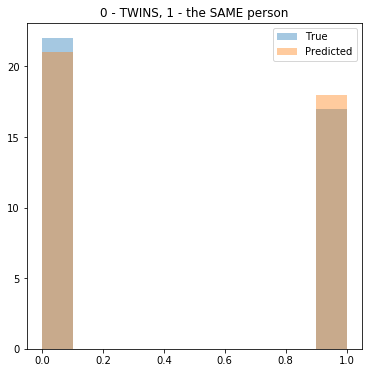

In [0]:
plt.figure(figsize=(6,6))
plt.hist(v_y, alpha=0.4, label='True')
plt.hist(v_y_pred, alpha=0.4, label='Predicted')
plt.title('0 - TWINS, 1 - the SAME person')
plt.legend()
plt.show()

In [0]:
accuracy_score(v_y, v_y_pred)

0.9743589743589743

**Test on fraternal class**

In [0]:
X_test = np.array(fraternal_lines)[:,48:]
y_test = np.ones(len(X_test)).astype(int)

In [0]:
fraternal_pred = svm.predict(X=X_test)

In [0]:
accuracy_score(y_test, fraternal_pred)

0.2357142857142857